In [2]:
import pandas as pd

# Load the dataset
file_path = 'MMM_test_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [3]:
import numpy as np

def adstock_transform(spend, theta):
    adstocked_spend = np.zeros_like(spend)
    adstocked_spend[0] = spend[0]
    for t in range(1, len(spend)):
        adstocked_spend[t] = spend[t] + theta * adstocked_spend[t-1]
    return adstocked_spend

# Apply adstock transformation to each channel with an assumed decay rate (e.g., 0.5)
theta = 0.5
for i in range(1, 8):
    data[f'adstock_channel_{i}'] = adstock_transform(data[f'spend_channel_{i}'].values, theta)

# Display the dataset with adstock columns
data.head()


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,adstock_channel_1,adstock_channel_2,adstock_channel_3,adstock_channel_4,adstock_channel_5,adstock_channel_6,adstock_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,2625.48000,262.710000,12954.1200,3609.630000,12955.290000,12659.120,19379.790000
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,3946.75000,240.015000,15237.3400,6365.415000,19225.345000,18667.740,32163.345000
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,4060.45500,230.327500,14774.0900,7545.667500,24628.082500,20145.020,38677.722500
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,3720.92750,167.953750,22572.2650,7656.243750,27835.451250,22962.730,44067.591250
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,3407.76375,164.536875,29810.1825,7871.211875,29711.465625,24123.915,48549.275625


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

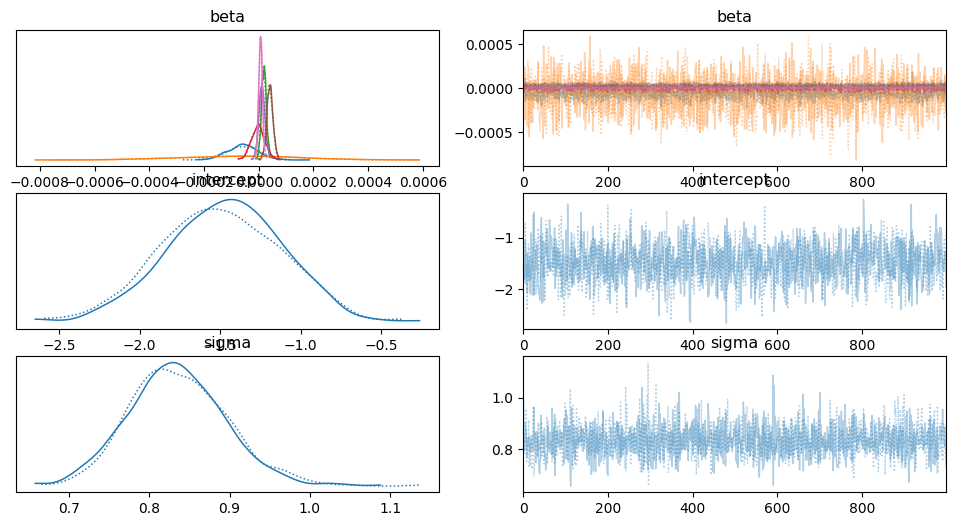

In [4]:
import pymc as pm
import arviz as az
import numpy as np

# Standardize the revenue for better sampling
data['revenue_std'] = (data['revenue'] - data['revenue'].mean()) / data['revenue'].std()

# Adstock transformation function
def adstock_transform(spend, theta):
    adstocked_spend = np.zeros_like(spend)
    adstocked_spend[0] = spend[0]
    for t in range(1, len(spend)):
        adstocked_spend[t] = spend[t] + theta * adstocked_spend[t-1]
    return adstocked_spend

# Apply adstock transformation to each channel with an assumed decay rate (e.g., 0.5)
theta = 0.5
for i in range(1, 8):
    data[f'adstock_channel_{i}'] = adstock_transform(data[f'spend_channel_{i}'].values, theta)

# Bayesian mixed-media model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=7)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Adstocked spend matrix
    X = data[[f'adstock_channel_{i}' for i in range(1, 8)]].values

    # Linear model
    mu = intercept + pm.math.dot(X, beta)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data['revenue_std'])

    # Sampling
    trace = pm.sample(1000, tune=1000, cores=2)

# Plotting the trace
az.plot_trace(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

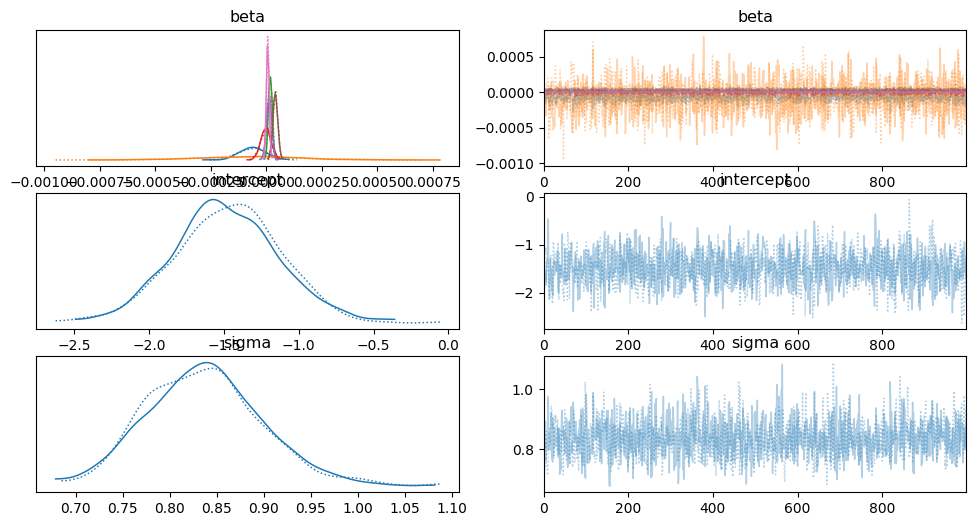

In [40]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Standardize the revenue for better sampling
data['revenue_std'] = (data['revenue'] - data['revenue'].mean()) / data['revenue'].std()

# Adstock transformation function
def adstock_transform(spend, theta):
    adstocked_spend = np.zeros_like(spend)
    adstocked_spend[0] = spend[0]
    for t in range(1, len(spend)):
        adstocked_spend[t] = spend[t] + theta * adstocked_spend[t-1]
    return adstocked_spend

# Apply adstock transformation to each channel with an assumed decay rate (e.g., 0.5)
theta = 0.5
for i in range(1, 8):
    data[f'adstock_channel_{i}'] = adstock_transform(data[f'spend_channel_{i}'].values, theta)

# Bayesian mixed-media model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=7)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Adstocked spend matrix
    X = data[[f'adstock_channel_{i}' for i in range(1, 8)]].values

    # Linear model
    mu = intercept + pm.math.dot(X, beta)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data['revenue_std'])

    # Sampling
    trace = pm.sample(1000, tune=1000, cores=2, return_inferencedata=True)

# Plotting the trace
az.plot_trace(trace)


Sampling: [likelihood]


Output()

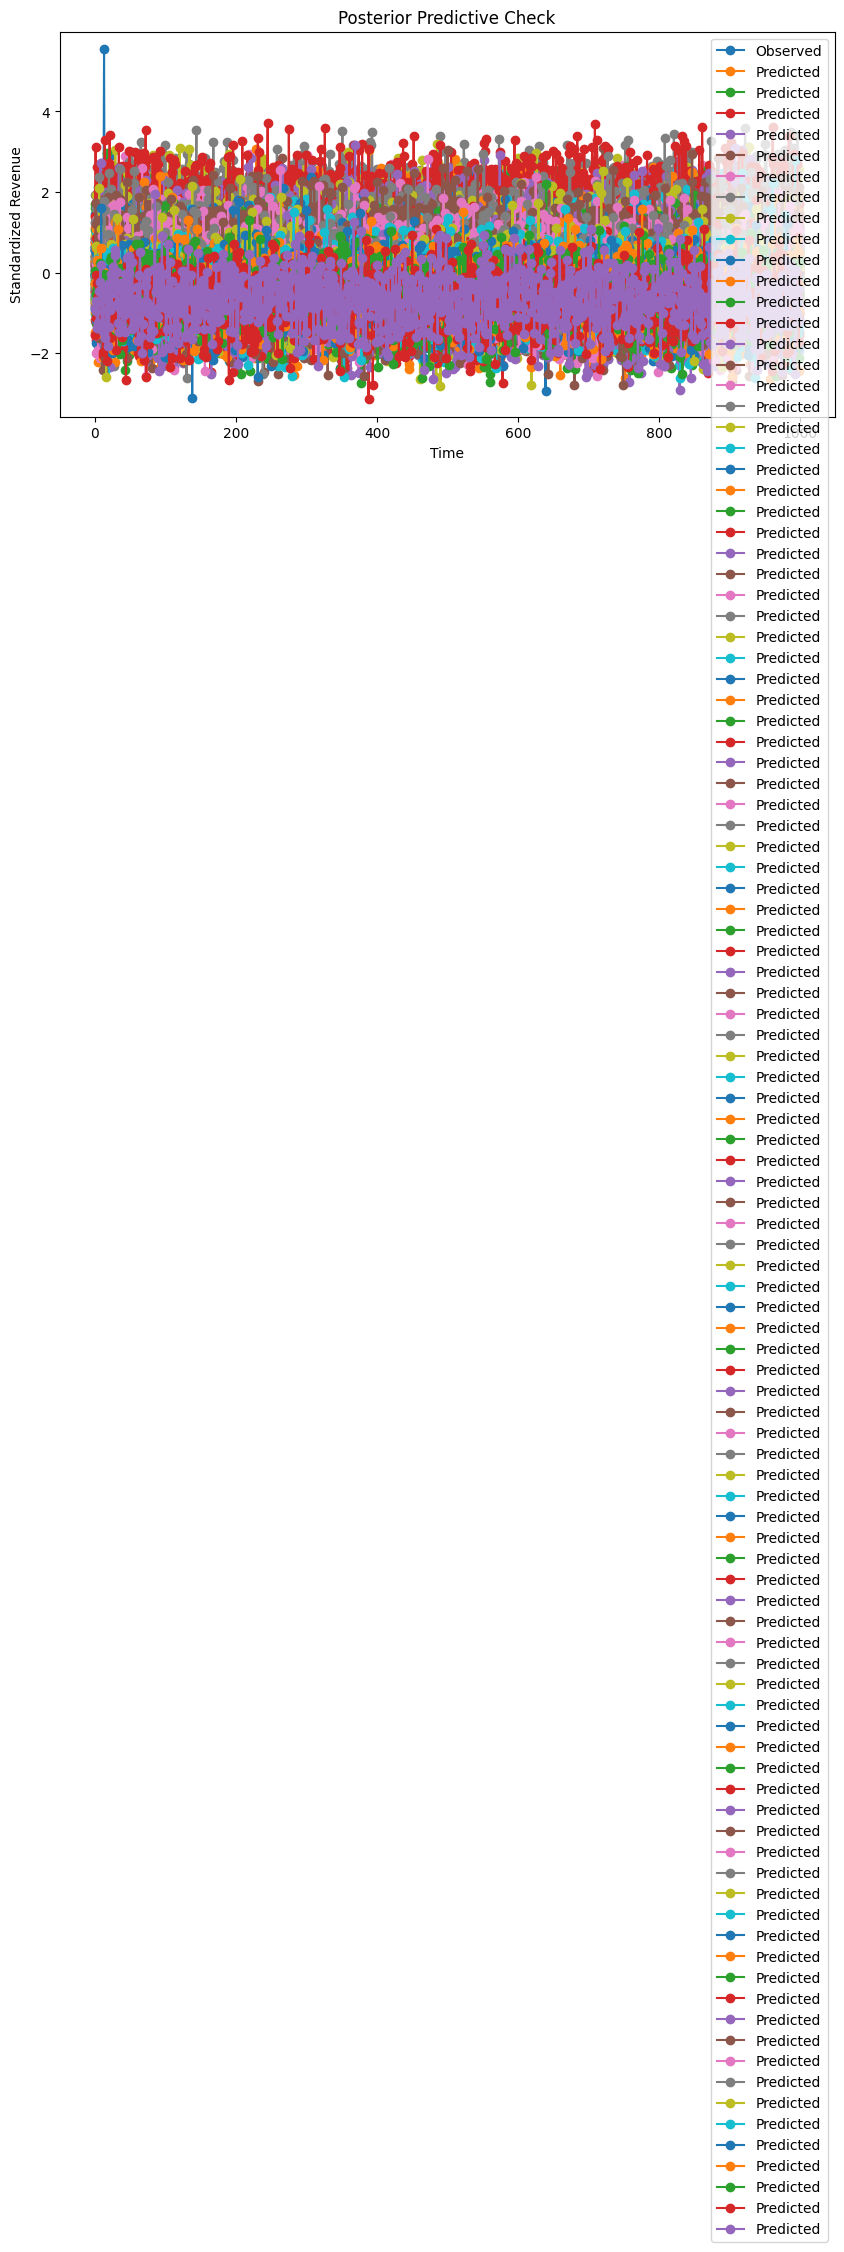

In [41]:
# Posterior predictive check
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["likelihood"], random_seed=42)

# Access the posterior predictive samples
posterior_predictive_samples = ppc.posterior_predictive['likelihood']

# Extracting the mean of the posterior predictive samples
ppc_mean = posterior_predictive_samples.mean(axis=0)

# Plotting the observed vs. predicted revenue
plt.figure(figsize=(10, 5))
plt.plot(data['revenue_std'], label='Observed', marker='o')
plt.plot(ppc_mean, label='Predicted', marker='o')
plt.xlabel('Time')
plt.ylabel('Standardized Revenue')
plt.legend()
plt.title('Posterior Predictive Check')
plt.show()



In [42]:
# Summary of the trace
summary = az.summary(trace)
print(summary)

# Calculate ROI for each channel
channel_names = [f'adstock_channel_{i}' for i in range(1, 8)]
roi = {}
for i, channel in enumerate(channel_names):
    beta_mean = trace.posterior['beta'].mean(dim=['chain', 'draw']).values[i]
    spend_mean = data[channel].mean()
    roi[channel] = beta_mean / spend_mean

# Display ROI
roi


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -0.000  0.000  -0.000    0.000      0.000    0.000    1609.0   
beta[1]   -0.000  0.000  -0.001    0.000      0.000    0.000    1844.0   
beta[2]    0.000  0.000   0.000    0.000      0.000    0.000    1638.0   
beta[3]   -0.000  0.000  -0.000    0.000      0.000    0.000    1595.0   
beta[4]    0.000  0.000  -0.000    0.000      0.000    0.000    1066.0   
beta[5]    0.000  0.000   0.000    0.000      0.000    0.000    1275.0   
beta[6]    0.000  0.000  -0.000    0.000      0.000    0.000    1366.0   
intercept -1.482  0.350  -2.170   -0.860      0.010    0.007    1241.0   
sigma      0.837  0.061   0.719    0.945      0.002    0.001    1580.0   

           ess_tail  r_hat  
beta[0]      1433.0    1.0  
beta[1]      1531.0    1.0  
beta[2]      1468.0    1.0  
beta[3]      1252.0    1.0  
beta[4]      1295.0    1.0  
beta[5]      1361.0    1.0  
beta[6]      1281.0    1.0  
intercept    1284.0    1.0 

{'adstock_channel_1': -2.4837170790977972e-08,
 'adstock_channel_2': -1.0888167078904578e-07,
 'adstock_channel_3': 4.722401046559332e-10,
 'adstock_channel_4': -1.2689134856942288e-10,
 'adstock_channel_5': 7.265694292551653e-10,
 'adstock_channel_6': 4.044523955133989e-09,
 'adstock_channel_7': 1.260295162738203e-10}